In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

# Tokenization, Stopping and Stemming

In [2]:
def stopword_stemming(df):
    stops = set(stopwords.words("english"))
    stemmer = SnowballStemmer("english")
    from nltk.tokenize import TweetTokenizer
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    # Split the sentences to lists of words.
#     df['split'] = df['B'].str.strip().str.lower().str.replace(","," ").str.replace("."," ").str.replace("!","").str.split()
#     df = df.drop(columns=['B']) # Get rid of the old column.

    df["split"] = df["B"].apply(lambda x: tweet_tokenizer.tokenize(x))
    df = df.drop(columns=['B']) # Get rid of the old column.
    
    df['stopped_stemmed'] = df['split'].apply(lambda x: [stemmer.stem(item) for item in x if item not in stops and not item.startswith('@')])
    df = df.drop(columns=['split']) # Get rid of the old column.
    
    df['B'] =  df['stopped_stemmed'].apply(lambda x: " ".join(x))
    df = df.drop(columns=['stopped_stemmed']) # Get rid of the old column.
#     return  df.to_numpy()
    return df 
        
    

# Input: training and testing data

In [3]:
def inputTraining(case):
    df = pd.read_csv("./trainingandtestdata/training.1600000.processed.noemoticon.csv",encoding = "latin-1", header=None, usecols=[0,5],names=['A','B'],index_col=False)
    if case == 1:
        return df
    elif case == 2:
        return stopword_stemming(df)
    

def inputTesting():
    df = pd.read_csv("./trainingandtestdata/testdata.manual.2009.06.14.csv",encoding = "latin-1", header=None, usecols=[0,5],names=['A','B'],index_col=False)
    data = df.to_numpy()
    data = data[np.where(data[:,0]!=2)]
    return data

# Description of Data

In [4]:
# A = Polarity
# B = TweetID
# C = date of the tweet 
# D = query (lyx)
# E = user
# F = tweet

#-----------CLASS------------

#class 0 Negative 
#calss 4 Positive

# Creating Vocabulary

In [5]:
# creating vocabulary of all words in training data

def vocabulary(data):
    data_class0 = data[np.where(data[:,0]==0)]
#     data_class2 = data[np.where(data[:,0]==2)]
    data_class4 = data[np.where(data[:,0]==4)]
    dataClassList  = [data_class0,data_class4]
    vocab_class0 = dict()
    vocab_class2 = dict()
    vocab_class4 = dict()
    TotalVocab = dict()
    wc = []
    vocabClassList = [vocab_class0,vocab_class4]
    for i,j in zip(dataClassList,vocabClassList):
        totalWordCountInClass = 0
        tweetList = i[:,1]
        for tweet in tweetList:
#             tweetlist = tweet.replace(","," ").replace("."," ").split()
            tweetlist = tweet.split()
            for words in tweetlist:
                totalWordCountInClass+=1
                if words in j:
                    j[words]+=1
                    TotalVocab[words]+=1
                else:
                    j[words]=1
                    TotalVocab[words]=1
        wc.append(totalWordCountInClass)
    print("Vocalbulary done")
    return vocab_class0,vocab_class4, TotalVocab,wc
    

# Finding the paarameters

In [6]:
# finding parameters

def FindPhi(data):
    phi = np.zeros((2,1))
    phi[0,0] = (np.count_nonzero(data[:,0] == 0)+1)/(data.shape[0]+2)
#     phi[1,0] = (np.count_nonzero(data[:,0] == 2)+1)/(data.shape[0]+3)
    phi[1,0] = (np.count_nonzero(data[:,0] == 4)+1)/(data.shape[0]+2)
    return phi

def Findtheta(vocab_class0,  vocab_class4, TotalVocab,wc):
    #----------------------------------------------------------------------------------------
    theta = dict()
    #--------------------------------------------------------------------------------------------
   
    for words in TotalVocab:
        theta[words] = []
        if(True):
            theta_ofThe_Word = 0
            if words in vocab_class0:
                theta_ofThe_Word = (vocab_class0[words] + 1)/(wc[0] + len(TotalVocab))
            else:
                theta_ofThe_Word = 1/(wc[0] + len(TotalVocab))
            theta[words].append(theta_ofThe_Word)
            
    #---------------------------------------------------------------------------------------------
   
#     for words in TotalVocab:
        if(True):
            theta_ofThe_Word = 0
            if words in vocab_class4:
                theta_ofThe_Word = (vocab_class4[words] + 1)/(wc[1]+ len(TotalVocab))
            else:
                theta_ofThe_Word = 1/(wc[1]+ len(TotalVocab))
            theta[words].append(theta_ofThe_Word)
    #----------------------------------------------------------------------------------------------
    print("parameters calculated")
    return theta

# Testing: Accuracy and Confusion Matrix

In [7]:
def testing(TestingData,theta,phi,case,test):
    from nltk.tokenize import TweetTokenizer
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    prediction = []
    postiveProbality = []
    for tweet in TestingData[:,1]:
        class0 = phi[0,0]
        class4 = phi[1,0]
        
        #TESTING DATA
        if test == 0:
            if case ==1:
                tweetlist = tweet.replace(','," ").replace('.'," ").split()
            
            elif case ==2:
                stops = set(stopwords.words("english"))
                stemmer = SnowballStemmer("english")
                tokenizedTweet = tweet_tokenizer.tokenize(tweet)
                tweetlist =  [stemmer.stem(item) for item in tokenizedTweet if item not in stops and not item.startswith('@')]
       
        # TRAINING DATA
        if test == 1:
            tweetlist = tweet.split()
         
        #CALCULATE PROBABILTY
        for words in tweetlist:
            if words in theta:
                class0 += math.log(theta[words][0]) 
            else:
                class0 += math.log(1/(len(tweetlist) + len(theta)))
            
            if words in theta:
                class4 += math.log(theta[words][1]) 
            else :
                class4 += math.log(1/(len(tweetlist) + len(theta)))
        
        class0 += math.log(phi[0,0])
        class4 += math.log(phi[1,0])
        postiveProbality.append(class4)
        if class0 > class4:
            prediction.append(0)
        else:
            prediction.append(4)
    count =0
    correct_class0 = 0
    correct_class4 = 0
    incorrect_class0 = 0
    incorrect_class4 = 0
    for i in  range(TestingData.shape[0]):
        if prediction[i] == TestingData[i,0]:
            if prediction[i] == 0:
                correct_class0+=1
            else:
                correct_class4+=1
            count+=1
        else:
            if prediction[i]==0:
                incorrect_class4+=1
            else:
                incorrect_class0+=1
    
    confusionMatrix = np.array([[correct_class0,incorrect_class4],[incorrect_class0,correct_class4]])
    Accurarcy = (count/TestingData.shape[0])*100
        
    return Accurarcy,confusionMatrix,postiveProbality

# Function for Random Prediction

In [8]:
def randomPrediction(size):
    import random
    targets =[0,4]
    randomPrediction =[]
    for i in range(size):
        randomPrediction.append(random.choice(targets))
    return randomPrediction


# RECEIVER OPERATING CHARACTERSTIC  -  ROC

In [9]:
# function to plot ROC curve
from sklearn import metrics
import matplotlib.pyplot as plt
def ROC(y,prob_scores,label):
#     print(len(y))
#     print(len(prob_scores))
    (fpr, tpr, thresholds) = metrics.roc_curve(y, prob_scores, pos_label=label)
    auc = metrics.roc_auc_score(y, prob_scores)
    p, = plt.plot(fpr,tpr,label="area under curve is "+str(auc))
    plt.legend()
    plt.show()
    return p
    
    

# Part F: TF-IDF

In [10]:
def tfidf():
    print("-------------Question F --> PART A---------------------\n")
    import pandas as pd
    from sklearn.feature_extraction.text import TfidfVectorizer
    import pickle
    from sklearn.naive_bayes import GaussianNB
    import numpy as np
    from tqdm import tqdm
    
    with open('cleanData','rb') as f:
        data=pickle.load(f)

    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(data['B'])
    print("--------------Shape of Train vectorized data------------")
    print(tfidf.shape)
    print("--------------------------------------------------------\n")
    
        #----------TRAINING MODEL TAKES > 1 HOUR-------------------
#     clf_pf = GaussianNB()

#     for i in tqdm(range(0,1600000,1000)):
#         clf_pf.partial_fit(tfidf[i:i+1000].toarray(), data['A'][i:i+1000].to_numpy(), np.array([0,4]))
    #-----------------------------------------------------------

    #---------STORING MODEL TO SAVE TIME------------------------
#     with open("vivekModel",'wb') as f:
#         pickle.dump(clf_pf,f)
    #-----------------------------------------------------------
    
    
    # loading the model pickle
    with open("model",'rb') as f:
         model = pickle.load(f)
        
        
    TestingData = inputTesting()
    Testdataset = pd.DataFrame({'A': TestingData[:, 0], 'B': TestingData[:, 1]})
    CleanTestData=stopword_stemming(Testdataset)
    tfidfTest = vectorizer.transform(CleanTestData['B'])
    print("--------------Shape of Test vectorized data------------")
    print(tfidfTest.shape)
    print("--------------------------------------------------------\n")
    prediction = model.predict(tfidfTest.toarray())
    tfidfProb = model.predict_proba(tfidfTest.toarray())[:,1]
    # print(prediction)
    
    match = 0
    for i in range(len(prediction)):
        if prediction[i] == CleanTestData["A"][i]:
            match += 1
    accurarcy = (match*100)/len(prediction)
    print("Accrarcy is ",accurarcy)
    print("--------------------------------------------------------\n")
    return tfidfProb

# SKLearn SelectPercentile 

In [11]:
def selectPercenttile():
    print("-------------Question F --> PART B---------------------\n")
    from sklearn.feature_selection import SelectPercentile, chi2, f_classif
    from sklearn.feature_extraction.text import TfidfVectorizer
    import pickle
    from sklearn.naive_bayes import GaussianNB
    import numpy as np
    from tqdm import tqdm
    
    with open('cleanData','rb') as f:
        data=pickle.load(f)
        
    vectorizer = TfidfVectorizer()
    X_new = vectorizer.fit_transform(data['B'],data["A"])
    print("--------------Shape of Train vectorized data------------")
    print(X_new.shape)
    perSel = SelectPercentile(f_classif,percentile=10)
    newFeature = perSel.fit_transform(X_new,data['A'].tolist())
    print(newFeature.shape)
    print("--------------------------------------------------------\n")
    
#     clf_pf = GaussianNB()

#     for i in tqdm(range(0,1600000,1000)):
#         clf_pf.partial_fit(newFeature[i:i+1000].toarray(), data['A'][i:i+1000].to_numpy(), np.array([0,4]))

    #---------STORING MODEL TO SAVE TIME------------------------
#     with open("vivekModel2",'wb') as f:
#         pickle.dump(clf_pf,f)
    #-----------------------------------------------------------
    
    
    with open("vivekModel2",'rb') as f:
        newmodel = pickle.load(f)
    
    TestingData = inputTesting()
    Testdataset = pd.DataFrame({'A': TestingData[:, 0], 'B': TestingData[:, 1]})
    CleanTestData=stopword_stemming(Testdataset)

    tfidfTest = vectorizer.transform(CleanTestData['B'])
    print("--------------Shape of Test vectorized data------------")
    print(tfidfTest.shape)
    newFeatureTest = perSel.transform(tfidfTest)
    print(newFeatureTest.shape)
    prediction = newmodel.predict(newFeatureTest.toarray())
    percentcileProb = newmodel.predict_proba(newFeatureTest.toarray())[:,1]
    print("--------------------------------------------------------\n")
    
    match = 0
    for i in range(len(prediction)):
        if prediction[i] == CleanTestData["A"][i]:
            match += 1
    accurarcy = (match*100)/len(prediction)
    print("Accrarcy is ",accurarcy)
    print("--------------------------------------------------------\n")
    return percentcileProb

# Function for structurally call the functions:  Part A B C D

In [12]:
def main():
    '''test 0 represents testing data
    test 1 represents training data'''
    case = 2
    part = ""
    if case ==1:
        part ='A'
    else:
        part ='D'
        
    startTime = time.time()
    TrainingDataFrame = inputTraining(case)
    TrainingData = TrainingDataFrame.to_numpy()
    
    #--------------------------------------------------------------------------
    #creating pickle of the clean data for further use
    if case ==2:
        import pickle
        with open("cleanData",'wb') as f:
            pickle.dump(TrainingDataFrame, f, protocol=pickle.HIGHEST_PROTOCOL)
    #--------------------------------------------------------------------------
    
    (vocab_class0,vocab_class4, TotalVocab,wc) = vocabulary(TrainingData)
    phi = FindPhi(TrainingData)
    theta  = Findtheta(vocab_class0,  vocab_class4, TotalVocab,wc)
    TestingData = inputTesting()
    
    print("------------------------------PART 1-{}-------------------".format(part))
    #TESTING DATA
    (AccurarcyTest,confusionMatrixTest,postiveProbalityTest) = testing(TestingData,theta,phi,case,0)
    print("Accuracy over Testing data is : ",AccurarcyTest,"%")
    
    #TRAINING DATA
    (AccurarcyTrain ,confusionMatrixTrain,postiveProbalityTrain)= testing(TrainingData,theta,phi,case,1)
    print("Accuracy over Training data is : ",AccurarcyTrain,"%")
    
    print("---------------------------------------------------------\n")
    endTime = time.time()-startTime
    print("-----------------------TIME TAKEN------------------------")
    print("Total time taken is :",endTime)
    print("---------------------------------------------------------\n")
    
    
    print("-----------------------------PART 1-B---------------------")
    print("-------------------RANDOM PREDICTION FOR TEST-------------\n")
    randomPredict =randomPrediction(TestingData.shape[0])

    match = 0
    for i in range(TestingData.shape[0]):
        if randomPredict[i] == TestingData[i,0]:
            match +=1
    randomAcc = (match*100)/TestingData.shape[0]
    print("Random guessing accuracy is ",randomAcc)
    print("\n")
    print("-------------------MAJORITY PREDICTION--------------------\n")
    print("Since both targets are equally distributed in training data \n")
    count4 = np.count_nonzero(TestingData[:,0]==4)
    count0 = TestingData.shape[0] - count4
    A4 = (count4*100)/TestingData.shape[0]
    A0 = (count0*100)/TestingData.shape[0]
    print("Accurarcy after taking postive class as majority ",A0)
    print("Accurarcy after taking negative class as majority ",A4)

    print("----------------------------------------------------------\n")
    
    
    
    print("------------------------------PART 1-C-------------------")
    print("CONFUSION MATRIX FOR TEST DATA: ")
    print(" Actual \t\t Class 0 \t Class 1")
    print("predicted Class 0 \t",confusionMatrixTest[0,0],"\t\t",confusionMatrixTest[0,1])
    print("predicted Class 1 \t",confusionMatrixTest[1,0],"\t\t",confusionMatrixTest[1,1])
    print("\n")
    print("CONFUSION MATRIX FOR TRAIN DATA: ")
    print(" Actual \t\t Class 0 \t\t Class 4")
    print("predicted Class 0 \t",confusionMatrixTrain[0,0],"\t\t",confusionMatrixTrain[0,1])
    print("predicted Class 4 \t",confusionMatrixTrain[1,0],"\t\t\t",confusionMatrixTrain[1,1])
    print("---------------------------------------------------------\n")
    
    
    
    print("-----------------------------PART F-----------------------")
    tfidfProb = tfidf()
    percentcileProb = selectPercenttile()
   
    
    print("-----------------------------PART G-----------------------")
    print("---------------RECEIVER OPERATING CHARACTERSTIC-----------\n")
    print("ROC for Test")
    ROC(TestingData[:,0].tolist(),postiveProbalityTest,4)
#     print("ROC for Train")
#     ROC(TrainingData[:,0].tolist(),postiveProbalityTrain,4)
    print("ROC for TFIDF")
    ROC(TestingData[:,0].tolist(),tfidfProb,4)
    print("ROC for SelectPercentile")
    ROC(TestingData[:,0].tolist(),percentcileProb,4)
    print("----------------------------------------------------------\n")

Vocalbulary done
parameters calculated
------------------------------PART 1-D-------------------
Accuracy over Testing data is :  81.61559888579387 %
Accuracy over Training data is :  79.209 %
---------------------------------------------------------

-----------------------TIME TAKEN------------------------
Total time taken is : 336.37701869010925
---------------------------------------------------------

-----------------------------PART 1-B---------------------
-------------------RANDOM PREDICTION FOR TEST-------------

Random guessing accuracy is  47.910863509749305


-------------------MAJORITY PREDICTION--------------------

Since both targets are equally distributed in training data 

Accurarcy after taking postive class as majority  49.30362116991643
Accurarcy after taking negative class as majority  50.69637883008357
----------------------------------------------------------

------------------------------PART 1-C-------------------
CONFUSION MATRIX FOR TEST DATA: 
 Actual 		 

  0%|          | 0/1600 [00:00<?, ?it/s]

(1600000, 29362)
--------------------------------------------------------



100%|██████████| 1600/1600 [08:48<00:00,  3.03it/s]


--------------Shape of Test vectorized data------------
(359, 293612)
(359, 29362)
--------------------------------------------------------

Accrarcy is  55.43175487465181
--------------------------------------------------------

-----------------------------PART G-----------------------
---------------RECEIVER OPERATING CHARACTERSTIC-----------

ROC for Test


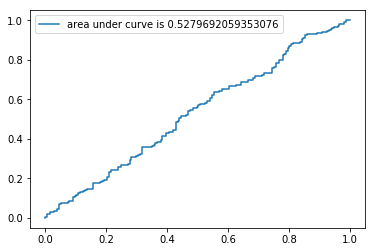

ROC for TFIDF


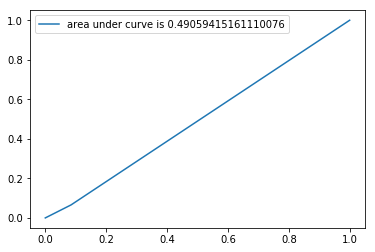

ROC for SelectPercentile


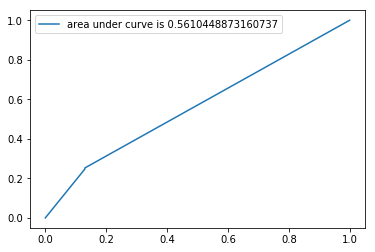

----------------------------------------------------------



In [13]:
main()


# Feature Engineering Bi-gram

In [36]:

def bigramification(data):
    for index in range(data.shape[0]):
        newData = []
        rowList = data[index,1].split()
        for i in range(len(rowList)-1):
            newData.append(rowList[i])
            newData.append(rowList[i]+rowList[i+1])
        data[index,1] = " ".join(newData.copy())
    return data


In [37]:
import pickle
with open('cleanData','rb') as f:
        trainData=pickle.load(f)
trainData = trainData.to_numpy()
train = bigramification(trainData)
(vocab_class0,vocab_class4, TotalVocab,wc) = vocabulary(train)
phi = FindPhi(train)
theta  = Findtheta(vocab_class0,  vocab_class4, TotalVocab,wc)

testData = inputTesting()
testDataFrame = pd.DataFrame({'A': testData[:, 0], 'B': testData[:, 1]})
CleanTestData = stopword_stemming(testDataFrame)
test = bigramification(CleanTestData.to_numpy())
#TESTING DATA
(Accurarcy ,confusionMatrixTrain,postiveProbalityTrain)= testing(test,theta,phi,2,0)
print("Accuracy over Testing data is : ",Accurarcy,"%")

Vocalbulary done
parameters calculated
Accuracy over Testing data is :  81.33704735376045 %
